In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.stats import gaussian_kde
import pandas as pd
from sklearn.model_selection import train_test_split
from joblib import dump
from joblib import load
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import Input
from sklearn.metrics import r2_score,mean_absolute_error
import time
import sys


In [4]:
col_names = ['lon', 'lat', 'lai_hv', 'wind',
          'temperature', 'rain', 'pressure',
          'radiation', 'biomass']
mydir = './good_data/'
datadir = './finaldata/'
lai = np.load(mydir+"lai_hv_interp_congo_025.npy")
wind = np.load(mydir+"wind_interp_congo_025.npy")
temp = np.load(mydir+"temperature_interp_congo_025.npy")
rain = np.load(mydir+"rain_interp_congo_025.npy")
pres = np.load(mydir+"pressure_interp_congo_025.npy")
radi = np.load(mydir+"radiation_interp_congo_025.npy")
lon = np.load(mydir+"gedi_lon_congo_025.npy")
lat = np.load(mydir+"gedi_lat_congo_025.npy")
y = np.load(mydir+"gedi_agbd_congo_025.npy")

alldata = np.concatenate((lat.reshape(-1,1),lon.reshape(-1,1),lai.reshape(-1,1),\
                    wind.reshape(-1,1),temp.reshape(-1,1),rain.reshape(-1,1),\
                    pres.reshape(-1,1),radi.reshape(-1,1),y.reshape(-1,1)),axis=1)
alldata = alldata[~np.isnan(alldata).any(axis=1)] # remove nan

only run if you need to save alldata for hyperparameter tuning

In [ ]:
alldata = pd.DataFrame(alldata, columns=col_names)
print(alldata.shape)
pd.DataFrame(alldata).to_csv(datadir+'all_data.csv',index=False)

In [5]:
X = alldata[:,:-1] # split into X
y = alldata[:,-1] # split into y

sc_X = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))

fitted_X_scaled = sc_X.fit_transform(X)
fitted_y_scaled = sc_y.fit_transform(y.reshape(-1,1))

# stratified random sampling
n_strata = 20 # cover 0-99% percentiles, the rest is assigned to the last strata bin
strata_bins = np.full([n_strata],np.nan)
for j in range(n_strata):
    strata_bins[j] = np.percentile(fitted_y_scaled,99/n_strata*(j+1))
strata_y = np.full([len(fitted_y_scaled),1],0)
for j in range(len(fitted_y_scaled)):
    if fitted_y_scaled[j] <= strata_bins[0]:
        strata_y[j] = 1
    elif fitted_y_scaled[j] <= strata_bins[n_strata-1]:
        for k in range(n_strata-1):
            if fitted_y_scaled[j] <= strata_bins[k+1] and fitted_y_scaled[j] > strata_bins[k]:
                strata_y[j] = k+1
    else:
        strata_y[j] = n_strata-1

X_train,X_test,y_train,y_test = train_test_split(fitted_X_scaled,fitted_y_scaled,test_size=0.2,stratify=strata_y,random_state=0)

In [30]:
# Build model
layers = [8, 25, 15, 20, 24, 19, 1]
I = layers[0]
J = layers[-1]
nodes = layers[1:-1]
input_part1 = Input(shape=(I,))
ann_part1 = Dense(units=nodes[0], activation='relu')(input_part1)
ann_part1 = Dense(units=nodes[1], activation='relu')(ann_part1)
ann_part1 = Dense(units=nodes[2], activation='relu')(ann_part1)
ann_part1 = Dense(units=nodes[3], activation='relu')(ann_part1)
ann_part1 = Dense(units=nodes[4], activation='relu')(ann_part1)
ann_out = Dense(units=1, activation='linear')(ann_part1)
model = tf.keras.Model(inputs=input_part1, outputs=ann_out)
model.summary()

myepochs = 1000
mybatch_size = 10

#change
opt = tf.keras.optimizers.RMSprop(learning_rate=0.000086988854789057)
model.compile(optimizer = opt,loss = 'mse')


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_6 (Dense)             (None, 25)                225       
                                                                 
 dense_7 (Dense)             (None, 15)                390       
                                                                 
 dense_8 (Dense)             (None, 20)                320       
                                                                 
 dense_9 (Dense)             (None, 24)                504       
                                                                 
 dense_10 (Dense)            (None, 19)                475       
                                                                 
 dense_11 (Dense)            (None, 1)                 20  

In [31]:
history = model.fit(X_train,y_train,\
              batch_size=mybatch_size,epochs=myepochs,\
              validation_data=(X_test,y_test))

model.save('congo_ann_initial.keras')
np.save('ann_initial_congo_history.npy',history.history)



Epoch 1/1000
202/202 [==============================] - 1s 2ms/step - loss: 0.0255 - val_loss: 0.0200
Epoch 2/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0190 - val_loss: 0.0195
Epoch 3/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0186 - val_loss: 0.0192
Epoch 4/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0182 - val_loss: 0.0188
Epoch 5/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0179 - val_loss: 0.0186
Epoch 6/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0176 - val_loss: 0.0183
Epoch 7/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.0173 - val_loss: 0.0181
Epoch 8/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0170 - val_loss: 0.0179
Epoch 9/1000
202/202 [==============================] - 0s 1ms/step - loss: 0.0168 - val_loss: 0.0177
Epoch 10/1000
202/202 [==============================] - 0s 2ms/step - loss: 0.016

: 

63/63 [==============================] - 0s 851us/step


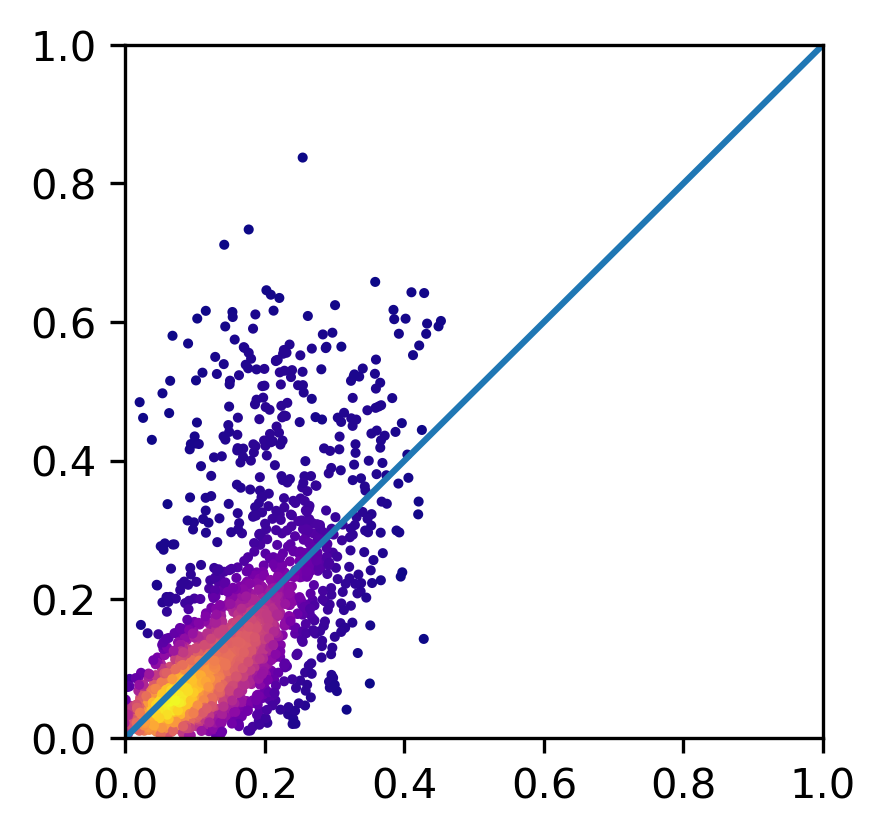

16/16 [==============================] - 0s 1ms/step


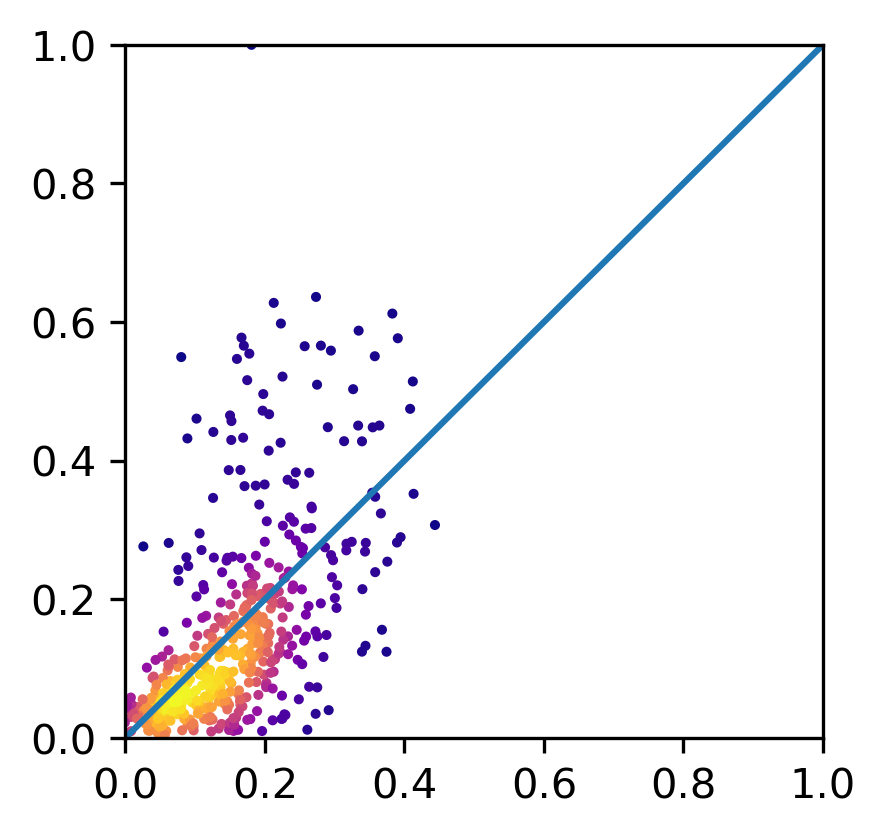

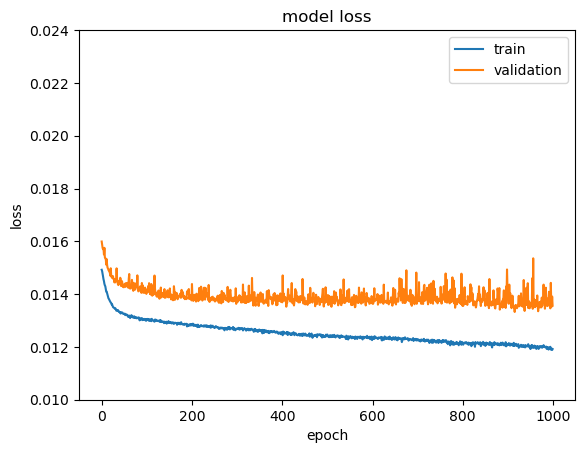

63/63 [==============================] - 0s 701us/step
0.3896379404308351
16/16 [==============================] - 0s 701us/step
0.317257158660463


In [29]:
from matplotlib.pyplot import figure

#visualize
y_pred = model.predict(X_train)

# Calculate the point density
xy = np.vstack((y_pred.reshape(-1,),y_train.reshape(-1,)))
color = gaussian_kde(xy)(xy)
#train
figure(figsize=(3,3), dpi=300)
plt.scatter(y_pred,y_train,label='Train',c=color,s=2,cmap='plasma')
plt.plot(range(0,2),range(0,2))
plt.xlim(0,1)
plt.ylim(0,1)
#plt.legend()
plt.show()

#test
y_pred = model.predict(X_test)
# Calculate the point density
xy = np.vstack((y_pred.reshape(-1,),y_test.reshape(-1,)))
color = gaussian_kde(xy)(xy)
#test
figure(figsize=(3,3), dpi=300)
plt.scatter(y_pred,y_test,label='Test',c=color,s=2,cmap='plasma')
plt.plot(range(0,2),range(0,2))
plt.xlim(0,1)
plt.ylim(0,1)
#plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim(0.01,0.024)
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

print(r2_score(y_train,model.predict(X_train)))
print(r2_score(y_test,model.predict(X_test)))

In [100]:
amazondir = '../amazonCodes/alldata/'
#load amazon data
lai_a = np.load(amazondir+"lai_hv_interp_025.npy")
wind_a = np.load(amazondir+"wind_interp_025.npy")
temp_a = np.load(amazondir+"temperature_interp_025.npy")
rain_a = np.load(amazondir+"rain_interp_025.npy")
pres_a = np.load(amazondir+"pressure_interp_025.npy")
radi_a = np.load(amazondir+"radiation_interp_025.npy")
lon_a = np.load(amazondir+"gedi_lon_025.npy")
lat_a = np.load(amazondir+"gedi_lat_025.npy")
y_a = np.load(amazondir+"gedi_agbd_025.npy")

alldata2 = np.concatenate((lat_a.reshape(-1,1),lon_a.reshape(-1,1),lai_a.reshape(-1,1),\
                    wind_a.reshape(-1,1),temp_a.reshape(-1,1),rain_a.reshape(-1,1),\
                    pres_a.reshape(-1,1),radi_a.reshape(-1,1),y_a.reshape(-1,1)),axis=1)
alldata2 = alldata2[~np.isnan(alldata2).any(axis=1)] # remove nan

DON'T RUN UNLESS YOU NEED TO SAVE ALLDATA2 

In [ ]:
alldata2 = pd.DataFrame(alldata2, columns=col_names)
print(alldata2.shape)
pd.DataFrame(alldata2).to_csv(mydir+'all_data.csv',index=False)

In [101]:
np.save(amazondir+'alldata2.npy',alldata2)

[]

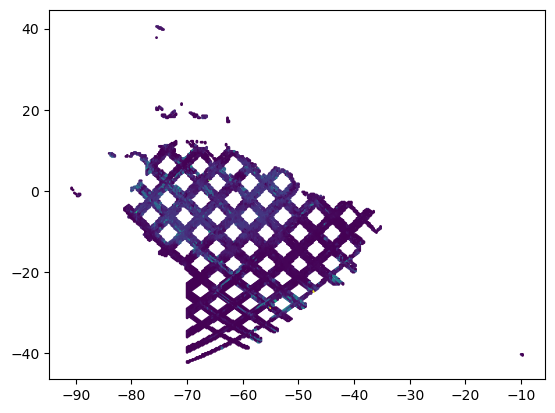

In [102]:
plt.scatter(alldata2[:,1],alldata2[:,0],cmap='viridis',c=alldata2[:,8],s=1)
plt.plot()

Trial 9 finished with value: 0.01986623350530863 and parameters: {'n_layers': 9, 'activation': 'sigmoid', 'out_activation': 'relu', 'n_units_l0': 13, 'n_units_l1': 11, 'n_units_l2': 12, 'n_units_l3': 6, 'n_units_l4': 6, 'n_units_l5': 11, 'n_units_l6': 11, 'n_units_l7': 6, 'n_units_l8': 11, 'optimizer': 'SGD', 'SGD_learning_rate': 0.0001949024356366169}. Best is trial 4 with value: 0.014281144738197327.

Trial 40 finished with value: 0.014607313834130765 and parameters: {'n_layers': 9, 'activation': 'relu', 'out_activation': 'relu', 'n_units_l0': 13, 'n_units_l1': 9, 'n_units_l2': 9, 'n_units_l3': 14, 'n_units_l4': 13, 'n_units_l5': 13, 'n_units_l6': 12, 'n_units_l7': 11, 'n_units_l8': 9, 'optimizer': 'RMSprop', 'RMSprop_learning_rate': 0.0003769103165284093}. Best is trial 33 with value: 0.013559369742870331.

In [103]:
X = alldata2[:,:-1] # split into X
y = alldata2[:,-1] # split into y

fitted_X_scaled = sc_X.transform(X)
fitted_y_scaled = sc_y.transform(y.reshape(-1,1))

# stratified random sampling
n_strata = 20 # cover 0-99% percentiles, the rest is assigned to the last strata bin
strata_bins = np.full([n_strata],np.nan)
for j in range(n_strata):
    strata_bins[j] = np.percentile(fitted_y_scaled,99/n_strata*(j+1))
strata_y = np.full([len(fitted_y_scaled),1],0)
for j in range(len(fitted_y_scaled)):
    if fitted_y_scaled[j] <= strata_bins[0]:
        strata_y[j] = 1
    elif fitted_y_scaled[j] <= strata_bins[n_strata-1]:
        for k in range(n_strata-1):
            if fitted_y_scaled[j] <= strata_bins[k+1] and fitted_y_scaled[j] > strata_bins[k]:
                strata_y[j] = k+1
    else:
        strata_y[j] = n_strata-1

X_train,X_test,y_train,y_test = train_test_split(fitted_X_scaled,fitted_y_scaled,test_size=0.2,stratify=strata_y,random_state=0)

Glorious K

In [214]:
k=5

In [215]:

model = load_model('congo_ann_initial.keras')

layers = len(model.layers)

#set all but the last 3 layers as untrainable
for i in range (k):
    model.layers[i].trainable = False
    
#model.compile(optimizer = opt,loss = 'mse')

history_amazon = model.fit(X_train,y_train,\
              batch_size=mybatch_size,epochs=myepochs,\
              validation_data=(X_test,y_test))
#save
np.save('ann_transfer_history_k_'+str(k)+'.npy',history_amazon.history)
#history_amazon=np.load('ann_transfer_history_k_.npy',allow_pickle='TRUE').item()
model.save('congo_ann_k_'+str(k)+'.keras')

Epoch 1/1000
1017/1017 [==============================] - 2s 1ms/step - loss: 0.0240 - val_loss: 0.0186
Epoch 2/1000
1017/1017 [==============================] - 1s 1ms/step - loss: 0.0142 - val_loss: 0.0152
Epoch 3/1000
1017/1017 [==============================] - 2s 2ms/step - loss: 0.0137 - val_loss: 0.0154
Epoch 4/1000
 783/1017 [======================>.......] - ETA: 0s - loss: 0.0135

KeyboardInterrupt: 

Save tranfered model **BE SURE TO CHANGE k**

In [208]:
model.save('congo_ann_k_'+str(k)+'.keras')

remember to change k

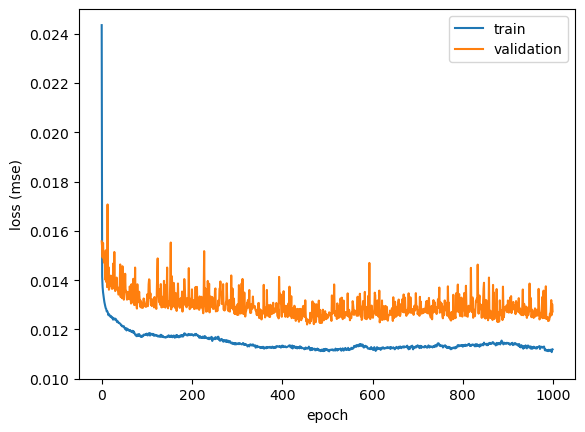

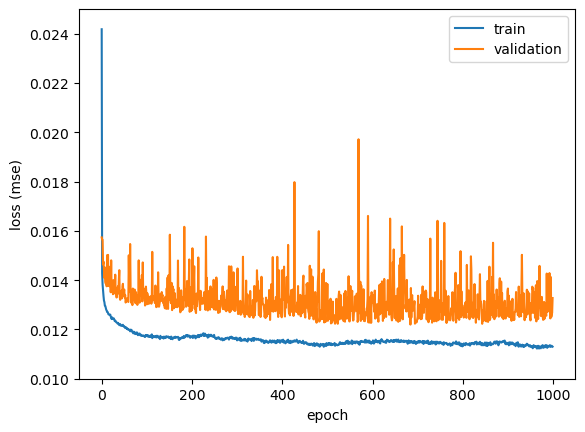

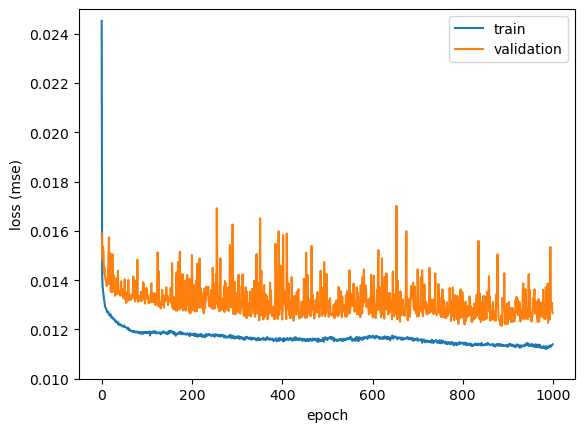

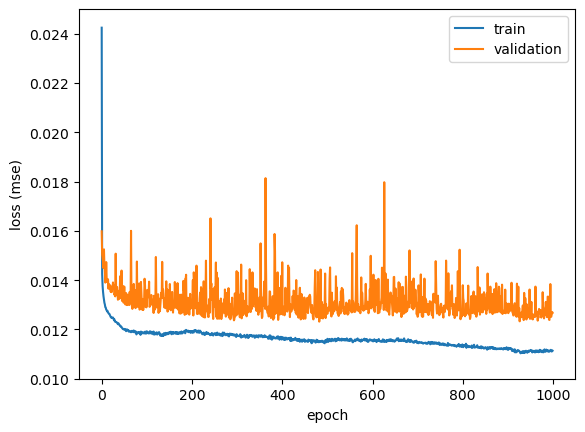

In [22]:
for k in range (1,5):
    history = np.load('ann_transfer_history_k_'+str(k)+'.npy', allow_pickle=True)
    plt.plot(history.item()['loss'])
    plt.plot(history.item()['val_loss'])
    plt.ylabel('loss (mse)')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.ylim(0.01,0.025)
    plt.show()
history = np.load('ann_transfer_history_k_'+str(k)+'.npy', allow_pickle=True)
    plt.plot(history.item()['loss'])
    plt.plot(history.item()['val_loss'])
    plt.ylabel('loss (mse)')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.ylim(0.01,0.025)
    plt.show()

318/318 [==============================] - 0s 765us/step


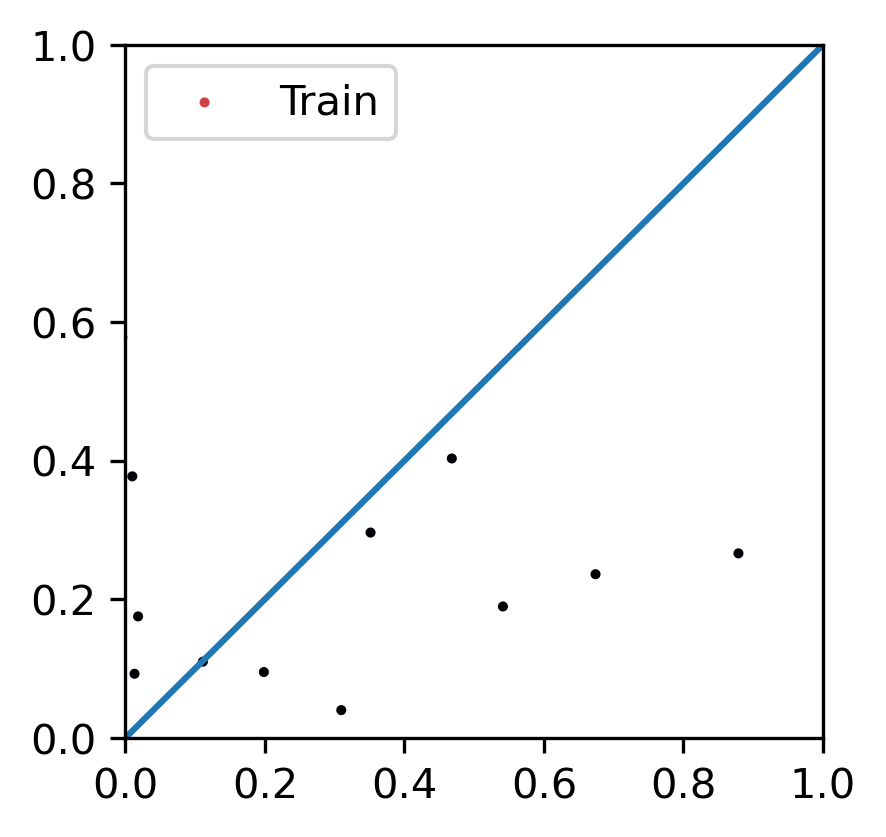

80/80 [==============================] - 0s 1ms/step


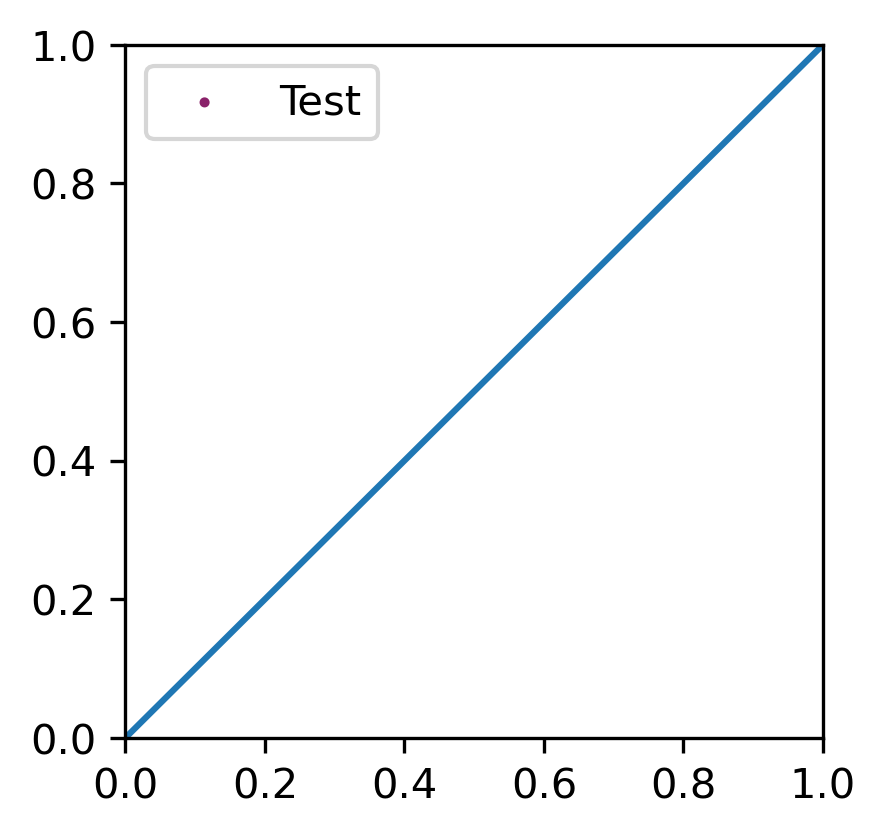

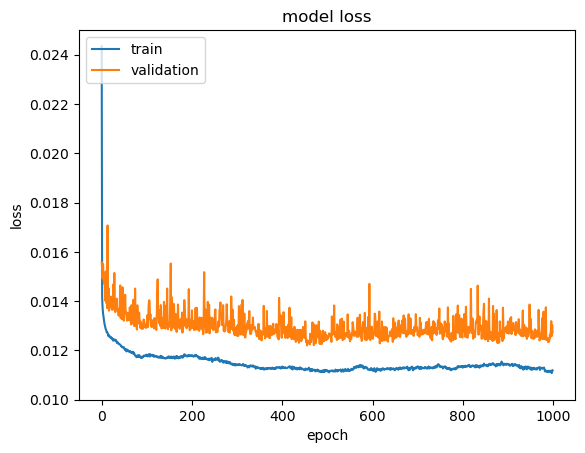

318/318 [==============================] - 0s 946us/step
-36.26535693482356
80/80 [==============================] - 0s 567us/step
-34.01505838515013


In [216]:
model = load_model('congo_ann_initial.keras')#'congo_ann_k_'+str(k)+'.keras')
#visualize
y_pred = model.predict(X_train)

# Calculate the point density
xy = np.vstack((y_pred.reshape(-1,),y_train.reshape(-1,)))
color = gaussian_kde(xy)(xy)
#train
figure(figsize=(3,3), dpi=300)
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(y_pred,y_train,label='Train',c=color,s=2,cmap='inferno')
plt.plot(range(0,2),range(0,2))
plt.legend()
plt.show()

#test
y_pred = model.predict(X_test)
# Calculate the point density
xy = np.vstack((y_pred.reshape(-1,),y_test.reshape(-1,)))
color = gaussian_kde(xy)(xy)
#test
figure(figsize=(3,3), dpi=300)
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(y_pred,y_test,label='Test',c=color,s=2,cmap='inferno')
plt.plot(range(0,2),range(0,2))
plt.legend()
plt.show()

history = np.load('ann_transfer_history_k_'+str(k)+'.npy')

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(0.01,0.025)
plt.show()

print(r2_score(y_train,model.predict(X_train)))
print(r2_score(y_test,model.predict(X_test)))

In [116]:
print(sum(y_a < 0))
print(color)
print(alldata2.shape[0])

0
[ 7.66341651 20.41224593  8.35940209 ... 11.67753242 50.98874094
 56.83045922]
12711


map biomass

In [149]:
print(data_nc.files)

['lai_hv', 'temperature', 'rain', 'radiation', 'pressure', 'wind']


[14637 14637 14637 14637 14637 14637 14637 14637]
458/458 [==============================] - 1s 1ms/step


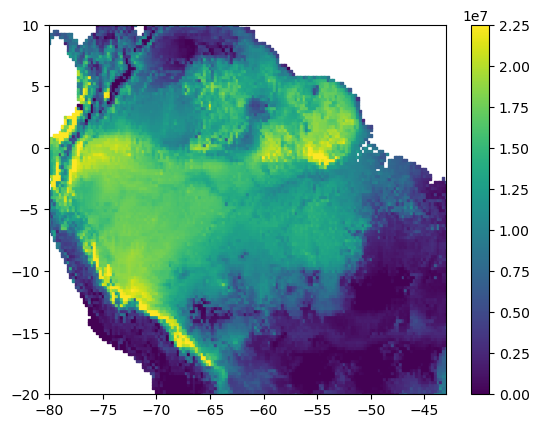

[1.3856362e+11]
458/458 [==============================] - 1s 1ms/step


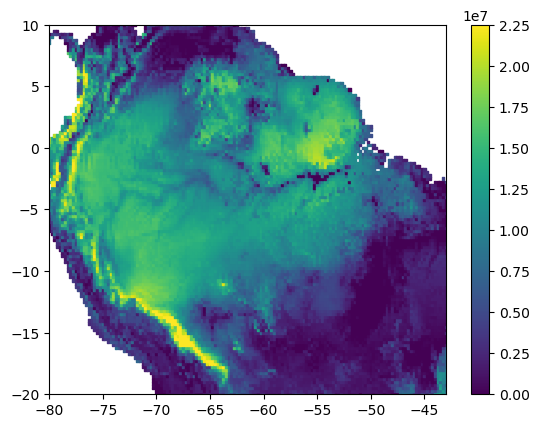

[1.18756109e+11]
458/458 [==============================] - 1s 1ms/step


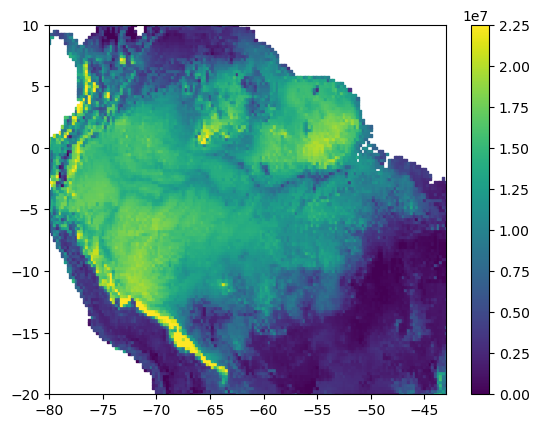

[1.34272039e+11]
458/458 [==============================] - 1s 1ms/step


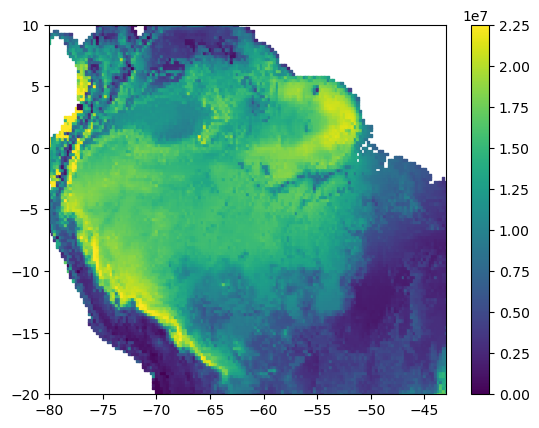

[1.57029186e+11]


In [6]:
import numpy.ma as ma
from scipy.interpolate import griddata

#lon
xmin = -80
xmax = -43
#lat
ymin = -20
ymax = 10
#(lon,lat)

X = np.arange(xmin, xmax+0.1, 0.1) # replace with ERA5 longitude
Y = np.arange(ymin, ymax+0.1, 0.1) # replace with ERA5 latitude
grid=[]
for i in range(len(X)):
    for j in range(len(Y)):
        grid.append([X[i], Y[j]])
grid = np.array(grid)

X = np.arange(xmin, xmax+0.25, 0.25) # replace with ERA5 longitude
Y = np.arange(ymin, ymax+0.25, 0.25) # replace with ERA5 latitude
grid_new=[]
for i in range(len(X)):
    for j in range(len(Y)):
        grid_new.append([X[i], Y[j]])
grid_new = np.array(grid_new)

amazondir = '../amazonCodes/'
data_nc = np.load(amazondir+'nctimeavg.npz')
mask = np.load(amazondir+'nctimeavg_ma.npz')

#X = np.concatenate((grid_new[:,1].reshape(-1,1), grid_new[:,0].reshape(-1,1)), axis=1)
for varname, varmask in zip(data_nc.files, mask.files):
    #reconstrtuct masked array
    temp = ma.array(data_nc[varname], mask = mask[varmask])
    temp = ma.filled(temp, fill_value = np.nan) 
    values=[]
    for i in range(len(grid)):
        #if np.isnan(temp[900 - int(grid[i,1] * 10)][(3600 + int(grid[i,0] * 10)) % 3600]):
         #   values.append(0)
        #else:
        values.append(temp[900 - int(grid[i,1] * 10)][(3600 + int(grid[i,0] * 10)) % 3600]) 
    data_new = griddata(grid, values, grid_new, method='nearest') 
    if varname == 'lai_hv':
        lai = data_new
    if varname == 'temperature':
        tempe = data_new
    if varname == 'wind':
        wind = data_new
    if varname == 'radiation':
        radi = data_new
    if varname == 'pressure':
        pres = data_new
    if varname == 'rain':
        rain = data_new
X = np.concatenate((grid_new[:,1].reshape(-1,1), grid_new[:,0].reshape(-1,1),lai.reshape(-1,1)\
                    ,wind.reshape(-1,1),tempe.reshape(-1,1),rain.reshape(-1,1),\
                    pres.reshape(-1,1),radi.reshape(-1,1)),axis=1)
X = X[~np.isnan(X).any(axis=1)] # remove nan
print(sum(~np.isnan(X)))

for k in range(1,5):
    model = load_model('congo_ann_k_'+str(k)+'.keras')
    fitted_X_scaled = sc_X.transform(X)
    y_pred = model.predict(fitted_X_scaled)
    y_est = sc_y.inverse_transform(y_pred.reshape(-1,1))
    y_est[y_pred <= 0] = 0
    #convert from density to biomass in Mg
    y_est = y_est * 75625
    plt.scatter(X[:,1], X[:,0], c=y_est, s=3, cmap='viridis', marker='s', vmax = 2.25e7)
    plt.colorbar()
    plt.ylim(ymin,ymax)
    plt.xlim(xmin,xmax)
    plt.show()
    print(sum(y_est))